In [38]:
import numpy as np
data = np.loadtxt('eeg.csv')

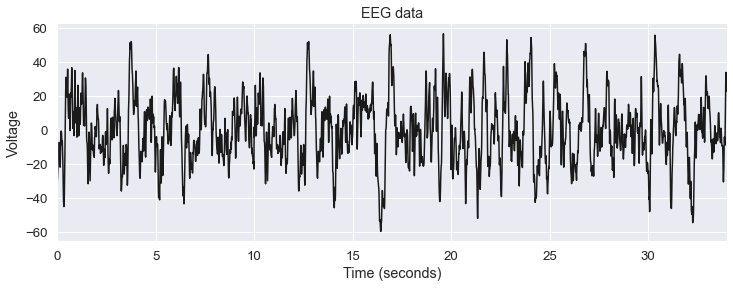

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency and time vector

sf = 100.
time = np.arange(data.size) / sf   # time = 20 secs (since data size is 2000)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))    # plotting eeg signal
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

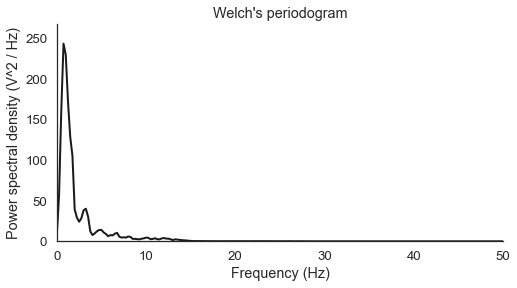

In [40]:
from scipy import signal

# Define window length (10 seconds)

win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win) 

"""
welch is a inbuilt function which provides array of sample frequencies and power spectral density

periodograms is helpful in estimating spectral power of signal 

Welch's method [1]_ computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified
                    periodogram for each segment and averaging the periodograms.
The power spectral density (PSD) of the signal describes the power present in the signal as a function of frequency, per unit frequency


"""
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)    # plot between power spectral density and frequnecy 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()


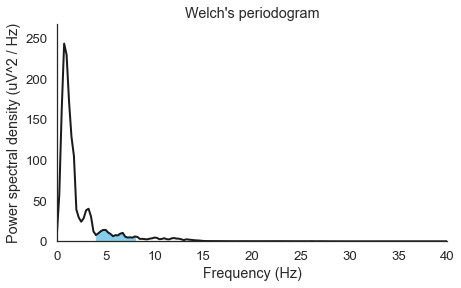

In [41]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_THETA = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_THETA, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 40])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [42]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
theta_power = simps(psd[idx_THETA], dx=freq_res)
print('Absolute power of theta band: %.3f uV^2' % theta_power)

Absolute power of theta band: 34.202 uV^2


In [43]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
theta_rel_power = theta_power / total_power
print('Relative bandpower of Theta band: %.3f' % theta_rel_power)

Relative bandpower of Theta band: 0.087


In [44]:

# defined function to compute bandpower of some set of freq of signal 
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    
    bandpower is an inbuilt function with provides absolute or relative band power of certain band freq of signal
    
    relative band power  =  power of some set of freq / total power of signal of signal 
    
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps  # simps is used to do integration of y(x) using samples along the xaxis
    
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [45]:
# useful of calculating band power of bands(like delta, beta, etc)
# Define the duration of the window to be 4 seconds
win_sec = 4 

# theta/beta ratio based on the absolute power
db = bandpower(data, sf, [4, 8], win_sec) / bandpower(data, sf, [12, 30], win_sec)

# theta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [4, 8], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

print('theta/alpha ratio (absolute): %.3f' % db)
print('theta/alpha ratio (relative): %.3f' % db_rel)

theta/alpha ratio (absolute): 4.331
theta/alpha ratio (relative): 4.331


In [46]:

def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """
    welch method
    Compute the average power of the signal x in a specific frequency band using welch method.
    this function returns
    bp(float) - Absolute or relative band power.

    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


In [47]:
# using welch's method
bp = bandpower(data, sf, [4, 8], 'welch')
bp_rel = bandpower(data, sf, [4, 8], 'welch', relative=True)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel)

# theta-alpha ratio

db = bandpower(data, sf, [4, 8], 'welch') / bandpower(data, sf, [12, 30], 'welch')

# Ratio based on the relative power
db_rel = bandpower(data, sf, [4, 8], 'welch', relative=True) / bandpower(data, sf, [12, 30], 'welch', relative=True)
print('theta/alpha ratio (absolute): %.3f' % db)
print('theta/alpha ratio (relative): %.3f' % db_rel)

Absolute theta power: 41.313
Relative theta power: 0.209
theta/alpha ratio (absolute): 4.214
theta/alpha ratio (relative): 1.669


In [48]:
# Multitaper theta power

bp = bandpower(data, sf, [4, 8], 'multitaper')
bp_rel = bandpower(data, sf, [4, 8], 'multitaper', relative=True)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel)

# theta-alpha ratio
# One advantage of the multitaper is that we don't need to define a window length.

db = bandpower(data, sf, [4, 8], 'multitaper') / bandpower(data, sf, [12, 30], 'multitaper')

# Ratio based on the relative power
db_rel = bandpower(data, sf, [4, 8], 'multitaper', relative=True) / bandpower(data, sf, [12, 30], 'multitaper', relative=True)
print('theta/alpha ratio (absolute): %.3f' % db)
print('theta/alpha ratio (relative): %.3f' % db_rel)

Absolute theta power: 35.644
Relative theta power: 0.093
theta/alpha ratio (absolute): 4.645
theta/alpha ratio (relative): 4.645


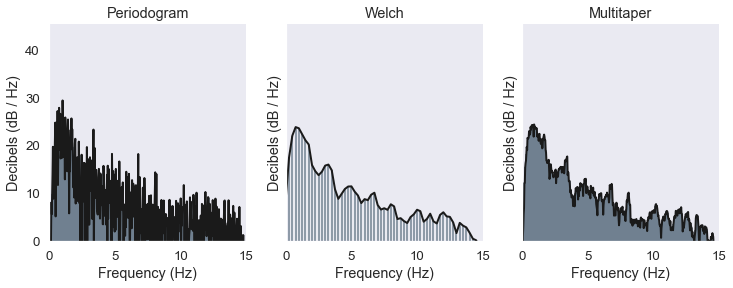

In [49]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD of theta band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="dark", font_scale=1.2)
    
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Frequency (Hz)')
    ax3.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    if not dB:
        ax2.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax2.set_ylabel('Decibels (dB / Hz)')
    if not dB:
        ax3.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax3.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

# Example: plot the 0.5 - 2 Hz band
plot_spectrum_methods(data, sf, 4, [0, 15], dB=True)


In [51]:
%timeit bandpower(data, sf, [4, 8], method="welch", relative=True)
%timeit bandpower(data, sf, [4, 8], method="multitaper", relative=True)

362 µs ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.3 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
